   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

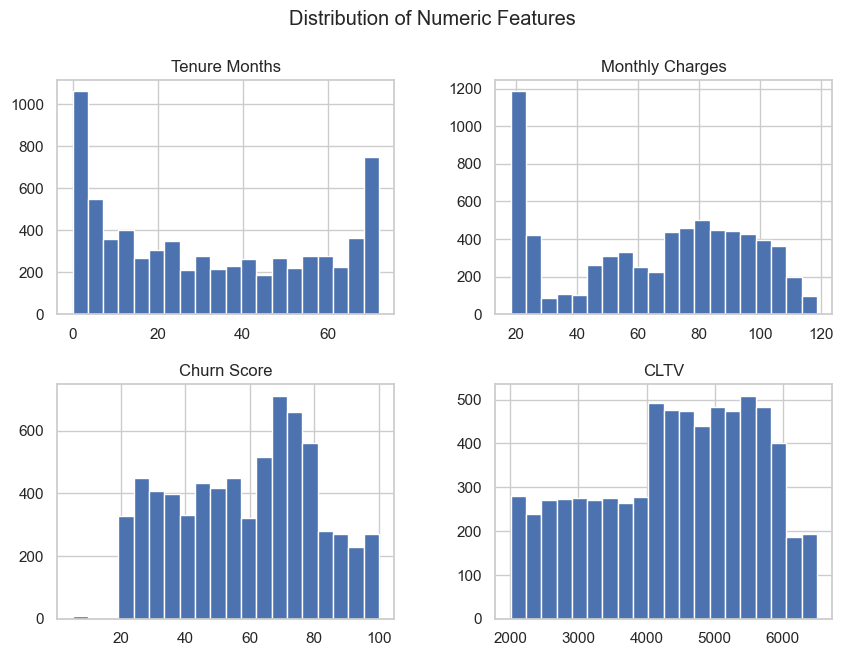

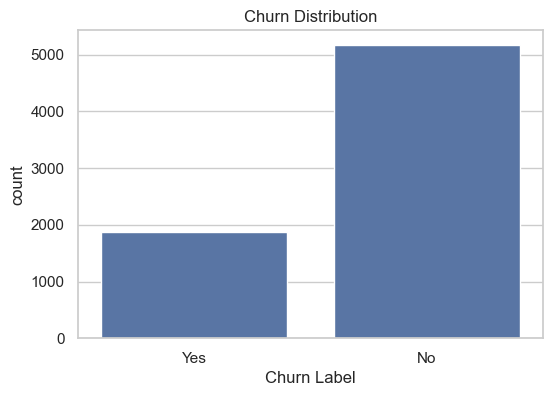

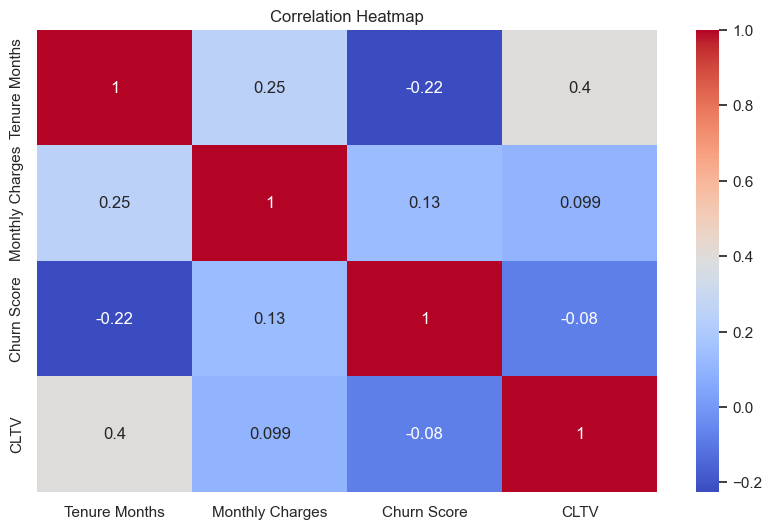

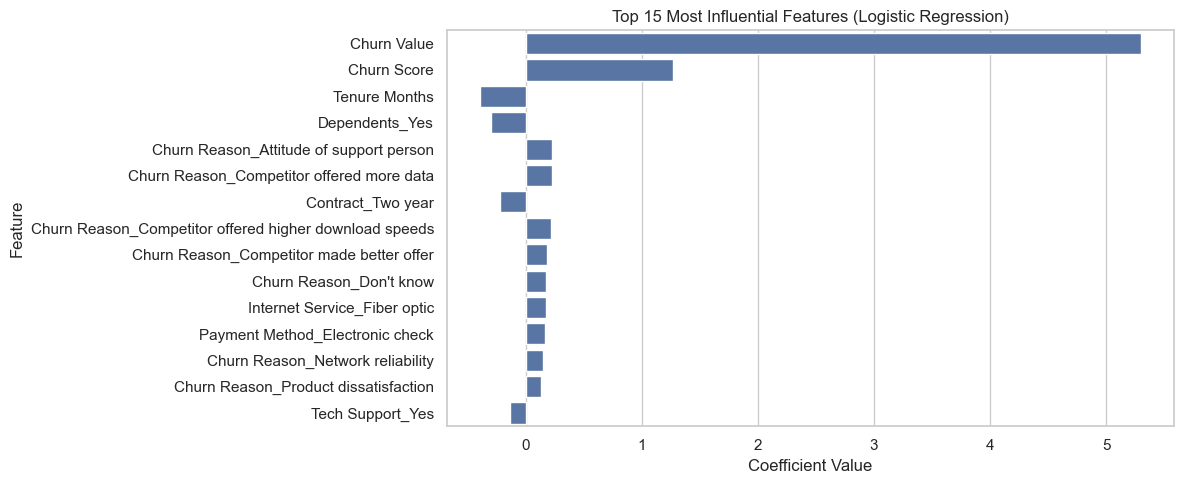

PR-AUC (Average Precision): 1.0


<Figure size 600x500 with 0 Axes>

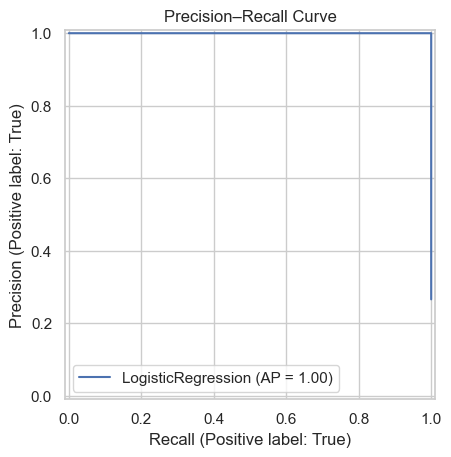

C:\Users\soban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\soban\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


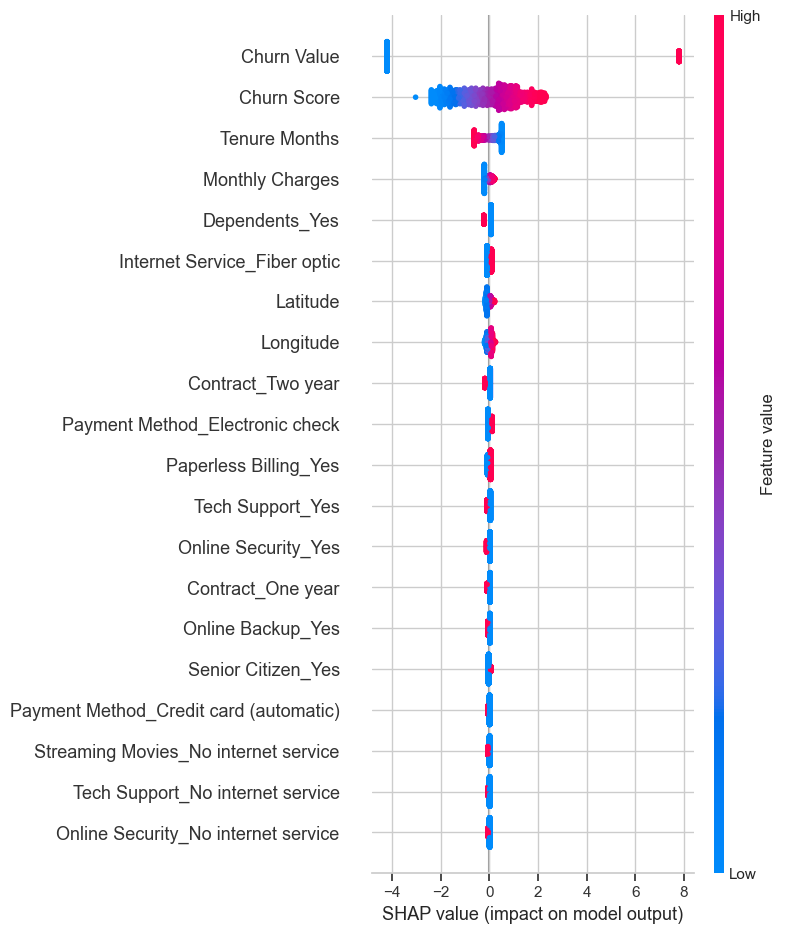

['feature_columns.pkl']

In [1]:
#A customer churn prediction ML model
import pandas as pd 

cp = pd.read_csv("C:/Users/soban/Downloads/Telco_customer_churn.csv")

print(cp.head())
print(cp.info())
print(cp.describe())
print(cp.value_counts())

#Determine if there are any missing values
if cp.isnull().values.any:
    print("CSV file has missing values.")
else:
    print("CSV file has no missing values.")
    
    
#Drop missing value columns >60%
#cp.drop(['Churn Reason'], axis=1, errors='ignore', inplace=True)
    
   
#Percentage of missing values per column
missing_percentages=(cp.isnull().sum()/len(cp))*100
print("Percentage of missing values per column:")
print(missing_percentages)

#Identify objects
id_objs=cp.select_dtypes(include=['object']).columns.tolist()
print("object identity:"), id_objs

#one hot encode to prevent dummy varible
cp_encoded = pd.get_dummies(cp, columns=id_objs, drop_first=True)
print(cp_encoded.shape)

#Set Up Feature Matrix (X) and Target (y)
y= cp_encoded['Churn Label_Yes']
x= cp_encoded.drop(['Churn Label_Yes'], axis=1)


#Split Data into Train and Test Sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
    )

#Scale Numeric Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Tenure Months', 'Monthly Charges', 'Churn Score', 'CLTV', 'Churn Value'] 

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

# Convert all columns to float (critical for SHAP)
x_train = x_train.astype(float)
x_test = x_test.astype(float)

#Train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")





#Data Visualizatiom
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

#Visualize Numerical Feature Distributions
num_cols = ['Tenure Months', 'Monthly Charges', 'Churn Score', 'CLTV']
cp[num_cols].hist(figsize=(10,7), bins=20)
plt.suptitle("Distribution of Numeric Features")
plt.show()


#Churn Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=cp, x="Churn Label")
plt.title("Churn Distribution")
plt.show()


#Feature Correlation Coefficients
plt.figure(figsize=(10,6))
sns.heatmap(cp[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


#Feature Importance Scale
# Get model coefficients
coefficients = model.coef_[0]
feature_names = x_train.columns

# Create a sorted Series (absolute values show importance)
feat_imp = pd.Series(coefficients, index=feature_names).sort_values(key=np.abs, ascending=False)

# Plot top 15 features
plt.figure(figsize=(12,5))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Precision-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve

# Compute the PR-AUC
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC (Average Precision):", pr_auc)

plt.figure(figsize=(6,5))
pr_display = PrecisionRecallDisplay.from_estimator(model, x_test, y_test)
plt.title("Precision–Recall Curve")
plt.show()

import json

# Save column order for API use
columns = x.columns.tolist()

with open("model_columns.json", "w") as f:
    json.dump(columns, f, indent=4)


import shap

#SHAP Explaination
explainer = shap.LinearExplainer(model, x_train, feature_perturbation="interventional")

# SHAP values for the test set (2D)
shap_values = explainer.shap_values(x_test)

# Create shap.Explanation object including base_values
shap_expl = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=x_test.values,
    feature_names=x_test.columns.tolist()
)

# --------------------------
# SUMMARY PLOT
# --------------------------
shap.summary_plot(shap_expl)

# --------------------------
# SINGLE-ROW SHAP (FORCE PLOT)
# --------------------------
# Pick first row and keep 2D with double brackets
single_row = x_test.iloc[[0]]

# Compute SHAP values
shap_values_single = explainer.shap_values(single_row)

# Create shap.Explanation object
shap_expl_single = shap.Explanation(
    values=shap_values_single,
    base_values=explainer.expected_value,
    data=single_row.values,
    feature_names=single_row.columns.tolist()
)

# Force plot (interactive in Jupyter)
shap.force_plot(explainer.expected_value, shap_values_single, single_row)




#Saving the model
import joblib

joblib.dump(model, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(x_train.columns.tolist(), "feature_columns.pkl")













